# Predicting Umpire Pitch Calls in the MLB

### Authors
Group ID: `29`

David Garcia: `100820537`

Ryan Don: `100824494`


In [1]:
!pip install -q torch matplotlib seaborn lightning torch torchinfo torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 36.0 MB/s eta 0:00:00


# Problem Formulation

Given that one of the suggested project ideas for the assignment was to perform a Kaggle data challenge, we chose to do: [Predict Strikes from MLB pitch-by-pitch data](https://www.kaggle.com/competitions/nwds-xstrikes/overview)

To paraphrase the challenge description, the goal is as follows. Using Major League Baseball and Google's [Statcast data](https://www.mlb.com/glossary/statcast), predict whether a pitch is going to be called a strike or not by the homeplate umpire.

For those unfamiliar with baseball knowledge, it may be helpful to provide some context. In baseball, a pitcher throws a ball to a batter (this is called a pitch) and the goal of the batter is to try to hit the ball. If the batter does not swing, the outcome of the call is either a ball or a strike. Pitches can be objectively called either a ball or a strike by a computer, but that is not the standard. The standard way is that the umpire who is behind home plate watches and makes the call if the ball falls inside the strike zone.

For more info on the strike zone here is a quote from the [MLB rulebook](https://www.mlb.com/glossary/rules/strike-zone):

>The official strike zone is the area over home plate from the midpoint between a batter's shoulders and the top of the uniform pants -- when the batter is in his stance and prepared to swing at a pitched ball -- and a point just below the kneecap. In order to get a strike call, part of the ball must cross over part of home plate while in the aforementioned area.
>
>Strikes and balls are called by the home-plate umpire after every pitch has passed the batter, unless the batter makes contact with the baseball (in which case the pitch is automatically a strike).

It is very common for umpires to call a pitch a strike even if it is outside of the zone, so the goal of this challenge is to try to predict the probability that a pitch is called either a ball or a strike by the umpire regardless of whether or not the pitch is objectively a strike. This presented an interesting challenge. As you will see, we quickly came up with a good model as far as accuracy, but since the competition is measuring log loss, we had to make improvements so our model would not end up being confidently incorrect.

![wikipedia strike zone](https://upload.wikimedia.org/wikipedia/commons/8/89/Strike_zone_en.JPG)

### Why does any of this matter?

If a pitcher is able to identify a part outside the strike zone that the umpire has a high probability of calling a strike, it would be in their best interest to throw there every so often. This is because pitches outside the zone are typically more difficult to hit for the batter. For context, a "ball" is good for the batter and a "strike" is good for the pitcher.

Therefore a batter might not swing at a ball outside the zone thinking it will be called a ball, whereas to their dismay, the umpire may decide it is a strike. If the pitcher can play along with this, it can give his team a significant advantage.

With all that being said...let's get into it!



# Dataset Collection


Kaggle competition link + dataset: https://www.kaggle.com/competitions/nwds-xstrikes/data

If you want to look at the data on kaggle, youll have to sign in and join the competition. We provide samples of the data, however, to give an idea of what we have to work with.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning as L
from torch import nn, optim
import torchmetrics
import torch
import torch.nn.functional as F

First we load our data and take a brief look at what we have.

In [53]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [54]:
train_df.head()

,uid,sz_top,sz_bot,pitch_type,release_pos_x,release_pos_y,release_pos_z,stand,p_throws,inning,...,on_2b,on_1b,release_speed,spin_axis,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z,is_strike
0,0,3.35,1.59,FF,-1.94,53.66,6.53,R,R,1,...,False,False,90.6,192,2192,-0.18,1.68,-0.01,1.97,1
1,1,3.53,1.70,FF,-1.90,53.57,6.39,R,R,1,...,False,False,92.6,196,2209,-0.20,1.67,0.66,2.62,1
2,2,3.67,1.73,FF,-1.87,53.51,6.40,R,R,1,...,False,False,91.6,187,2314,-0.16,1.61,0.55,2.28,1
3,3,3.65,1.72,FF,-1.97,53.65,6.36,R,R,1,...,False,False,93.5,194,2235,-0.36,1.79,-0.83,2.57,1
4,4,3.56,1.72,SL,-1.96,53.74,6.40,R,R,1,...,False,False,89.3,184,2314,0.32,1.25,1.18,1.41,0


It seems like we have a lot to work with. Not all of it seems like something that would affect the choice of an umpire, but there is a lot of useful data.

In [55]:
list(train_df.columns)

['uid',
 'sz_top',
 'sz_bot',
 'pitch_type',
 'release_pos_x',
 'release_pos_y',
 'release_pos_z',
 'stand',
 'p_throws',
 'inning',
 'inning_topbot',
 'outs_when_up',
 'balls',
 'strikes',
 'if_fielding_alignment',
 'of_fielding_alignment',
 'on_3b',
 'on_2b',
 'on_1b',
 'release_speed',
 'spin_axis',
 'release_spin_rate',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'is_strike']

The full descriptions for each of these are from [MLB Statcast](https://baseballsavant.mlb.com/csv-docs) (by Google).

For the ones we have in the challenge dataset, here is a quick glossary:

| Field | Description |
| :--- | :--- |
| `uid` | Unique ID |
| `sz_top` | Top of the batter's strike zone when the ball is halfway to the plate. |
| `sz_bot` | Bottom of the batter's strike zone when the ball is halfway to the plate. |
| `pitch_type` | Type of pitch derived from statcast |
| `release_pos_x` | Horizontal release pos of the ball from catcher's perspective |
| `release_pos_y` | Release pos of the pitch in feet from catcher |
| `release_pos_z` | Vertical release pos of the ball |
| `stand` | Handedness of the batter |
| `p_throws` | Hand the pitcher throws with |
| `inning` | Current inning |
| `inning_topbot` | Is it top or bottom of the inning |
| `outs_when_up` | Pre-pitch number of outs |
| `balls` | Pre-pitch number of balls in count |
| `strikes` | Pre-pitch number of strikes |
| `if_fielding_alignment` | Infield fielding alginment at time of pitch |
| `of_fielding_alignment` | Outfield fielding alignment at time of pitch |
| `on_3b` | Pre-pitch MLB player ID of runner on 3rd base |
| `on_2b` | ID of runner on 2nd base |
| `on_1b` | ID of runner on 1st base |
| `release_speed` | Pitch velocity |
| `spin_axis` | Spin axis when viewed from the front |
| `release_spin_rate` | Spin rate of pitch tracked by statcast |
| `pfx_x` | Total horizontal movement of the ball from the catcher's perspective |
| `pfx_z` | Vertical movement of the ball |
| `plate_x` | Horizontal pos of the ball when it crosses home plate |
| `plate_z` | Vertical pos of the ball when it crosses home plate |
| `is_strike` | IS THE BALL A STRIKE!! This is for validation |

We tried to only pick the inputs we thought would play an important factor in the umpire's call. A good chunk of this was just using our baseball intuition, but others are pretty obvious.

For example, the spin of the ball is what causes it to move horizontally or vertically. That information isn't necessary when we already have the horizontal and vertical movements.

In [56]:
numeric_features = [
    "plate_x", # Horizontal position of the ball when it crosses home plate from the catcher's perspective.
    "plate_z", # Vertical position of the ball when it crosses home plate from the catcher's perspective.
    "sz_top", # Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
    "sz_bot", # Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
    "balls", # Pre-pitch number of balls in count.
    "strikes", # Pre-pitch number of strikes in count.
    "release_speed", # Out of hand release speed.
    "pfx_x", # Horizontal movement in feet from the catcher's perspective.
    "pfx_z", # Vertical movement in feet from the catcher's perspective.
]

categorical_features = [
    "p_throws", # Handedness of the pitcher "L/R"
    "stand", # Handedness of the batter "L/R",
    # "pitch_type", # Pitch type
]

target = ["is_strike"]

You may notice that `pitch_type` is commented out. This is because depending on how the ball moves it can be classified as different pitch types like `fastball`, `slider`, `changeup`, `sweeper`, etc.

We think this could potentially affect the umpire's call, as the ball could be heading to the strike zone and then curve out at the last second.

With that being said, there are 12 different pitch types. If we wanted to add this to our input we would have to use one-hot encoding since we cannot just represent them as 0 through 11. If we did that, the model might think that a fastball is "more" than a slider, which makes no sense.

A solution to this would be one-hot encoding, but this would involve having 12 extra columns where one of them is 1 and the rest are 0 to represent the current pitch. This is inneficient and messy. The same information can be encapsulated by our `pfx` values combined with the `release_speed`

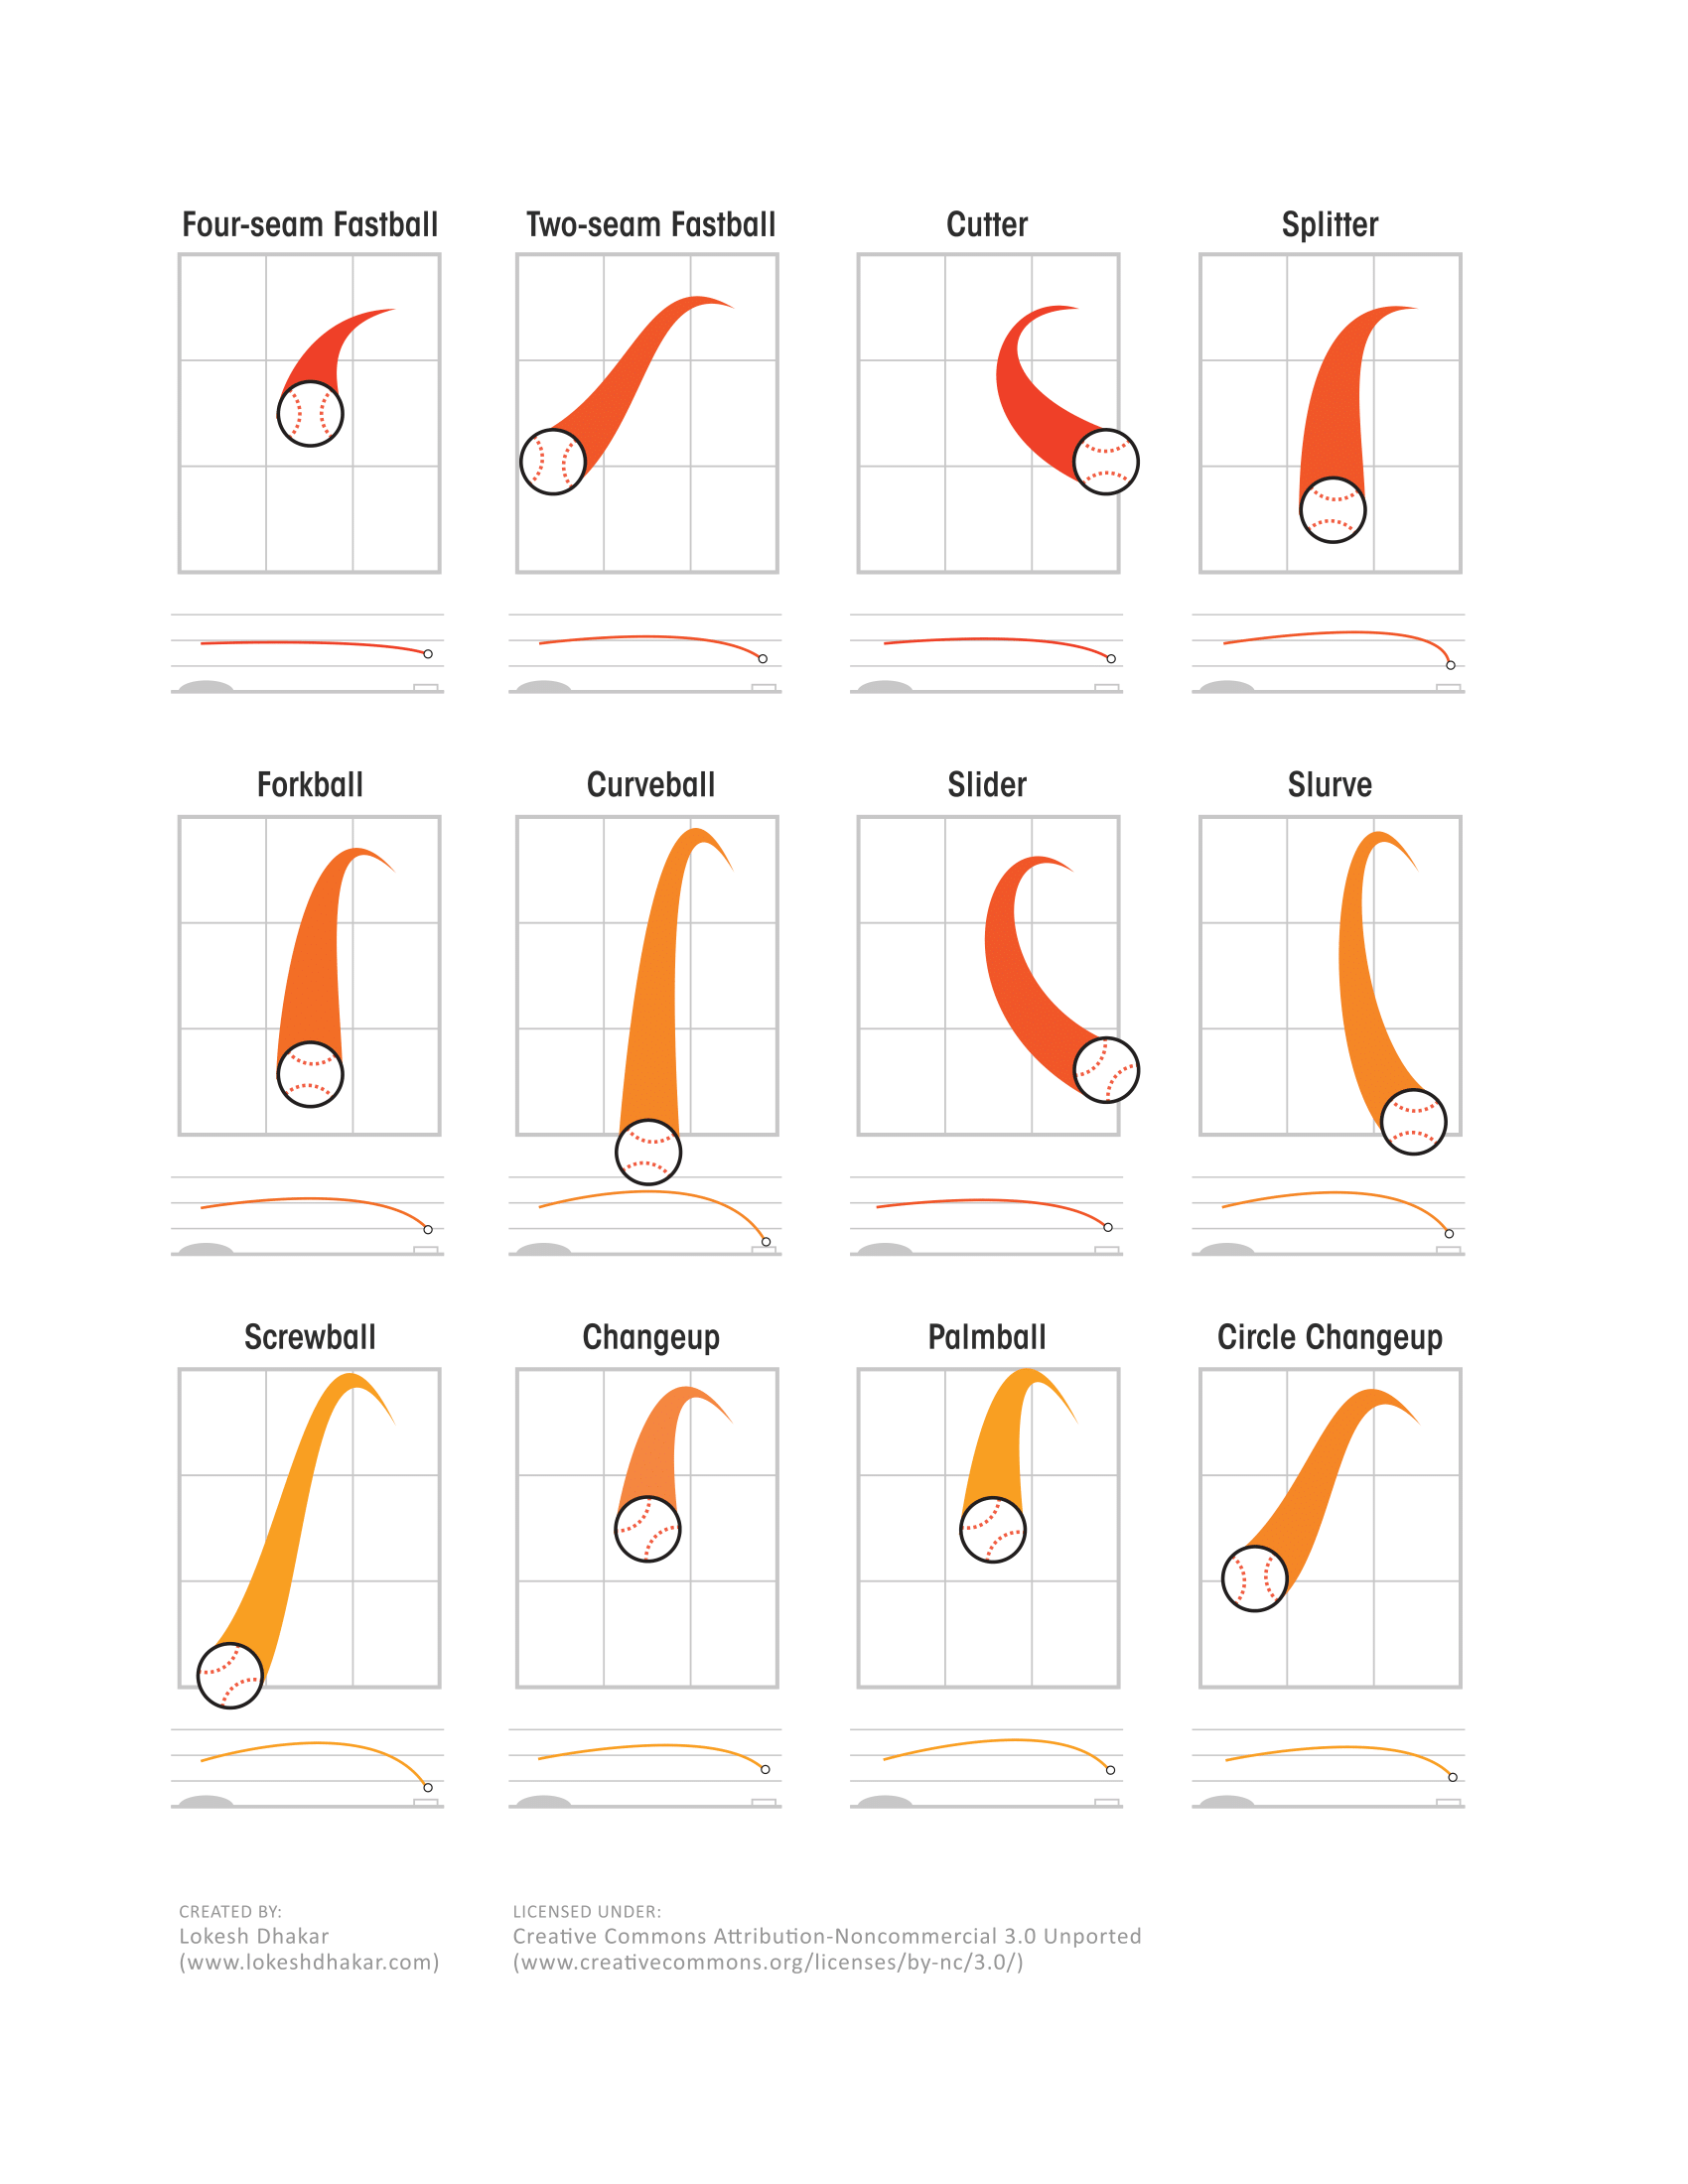

In [81]:
print(train_df["pitch_type"].unique())
print(len(train_df["pitch_type"].unique()))

['FF' 'SL' 'CU' 'CH' 'SI' 'FC' 'KC' 'FS' 'EP' 'FA' 'CS' 'KN']
12


Since we want the handedness of the pitcher and batter we, need to encode it into 0 and 1 since the MLP can't understand L and R.

In [58]:
train_df_simplified = train_df[numeric_features + categorical_features + target].copy()

# Encode handedness of pitcher and batter as 0 for Lefties and 1 for Righties
train_df_simplified["p_throws"] = train_df_simplified["p_throws"].map({"L": 0, "R": 1})
train_df_simplified["stand"] = train_df_simplified["stand"].map({"L": 0, "R": 1})

train_df_simplified.head()

,plate_x,plate_z,sz_top,sz_bot,balls,strikes,release_speed,pfx_x,pfx_z,p_throws,stand,is_strike
0,-0.01,1.97,3.35,1.59,0,0,90.6,-0.18,1.68,1,1,1
1,0.66,2.62,3.53,1.70,0,1,92.6,-0.20,1.67,1,1,1
2,0.55,2.28,3.67,1.73,0,0,91.6,-0.16,1.61,1,1,1
3,-0.83,2.57,3.65,1.72,0,1,93.5,-0.36,1.79,1,1,1
4,1.18,1.41,3.56,1.72,0,2,89.3,0.32,1.25,1,1,0


We decided to make this function to make it easy to clean the training and the testing dataset since it was already split up for the kaggle challenge to evaluate effectively.

Later when we train it, we split the `train.csv` into training and validation, but for the actual submission it uses data the model has never seen during training in `test.csv`.

In [59]:
def preprocessing_pipeline(df, is_train=True):
    numeric_features = [
    "plate_x", # Horizontal position of the ball when it crosses home plate from the catcher's perspective.
    "plate_z", # Vertical position of the ball when it crosses home plate from the catcher's perspective.
    "sz_top", # Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
    "sz_bot", # Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
    "balls", # Pre-pitch number of balls in count.
    "strikes", # Pre-pitch number of strikes in count.
    "release_speed", # Out of hand release speed.
    "pfx_x",
    "pfx_z",
    ]

    categorical_features = [
        "p_throws", # Handedness of the pitcher "L/R"
        "stand", # Handedness of the batter "L/R",
        # "pitch_type", # Pitch type
    ]

    if is_train:
        target = ["is_strike"]
        df_simplified = df[numeric_features + categorical_features + target].copy()
    else:
        df_simplified = df[numeric_features + categorical_features].copy()
    df_simplified["p_throws"] = df_simplified["p_throws"].map({"L": 0, "R": 1})
    df_simplified["stand"] = df_simplified["stand"].map({"L": 0, "R": 1})
    return df_simplified

Now we prepare the datasets to feed to the models for training and take a look inside every few steps to make sure everything makes sense.

In [60]:
# Create tensors for input and output

inputs = torch.tensor(
    train_df_simplified.drop(columns=["is_strike"]).values,
    dtype=torch.float32
)

targets = torch.tensor(
    train_df_simplified["is_strike"].values,
    dtype=torch.int64
)


In [61]:
inputs

tensor([[-0.0100,  1.9700,  3.3500,  ...,  1.6800,  1.0000,  1.0000],
        [ 0.6600,  2.6200,  3.5300,  ...,  1.6700,  1.0000,  1.0000],
        [ 0.5500,  2.2800,  3.6700,  ...,  1.6100,  1.0000,  1.0000],
        ...,
        [ 1.1700,  2.4800,  3.4600,  ...,  1.4400,  1.0000,  0.0000],
        [-1.2500,  2.4400,  3.2700,  ...,  0.4000,  1.0000,  0.0000],
        [ 0.8500,  4.0300,  3.2100,  ...,  1.1100,  1.0000,  1.0000]])

A batch size of 256 seems reasonable given that there are about 300k rows in `train.csv`.

In [62]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

batch_0 = next(iter(dataloader))
batch_0

[tensor([[ 0.2500,  3.9300,  3.4500,  ...,  1.4500,  0.0000,  1.0000],
         [ 1.2300,  1.2300,  3.2900,  ..., -0.1900,  1.0000,  1.0000],
         [-1.0700,  3.5100,  3.4700,  ..., -0.2700,  1.0000,  0.0000],
         ...,
         [ 0.1000,  2.5300,  3.3300,  ...,  1.2500,  1.0000,  0.0000],
         [ 1.1800,  3.2700,  3.0800,  ..., -0.3800,  0.0000,  1.0000],
         [-1.1900,  2.6400,  3.5400,  ...,  0.5500,  1.0000,  0.0000]]),
 tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
         0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
         0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
         0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

# Neural Network Design

First we started by taking inspiration from lab 5 and trying out the basic MLP from there, but with a larger batch size and hidden layer dimensions. This is because we have way more data and more powerful compute on colab.

In [63]:
class LinearClassifier(L.LightningModule):
  def __init__(self, input_size):
    super().__init__()
    self.nn = nn.Linear(input_size, 1)
    self.loss_fn = nn.BCEWithLogitsLoss()

  def forward(self, x):
    return self.nn(x).squeeze(1)

  def training_step(self, batch, batch_idx):
    x, target = batch
    target = target.float()
    logits = self.forward(x)
    loss = self.loss_fn(logits, target)
    return loss

  def configure_optimizers(self):
    return optim.Adam(self.parameters())

In [64]:
class MLP(LinearClassifier):
  def __init__(self, input_size, hidden):
    super().__init__(input_size)
    self.nn = nn.Sequential(
        nn.Linear(input_size, hidden),
        nn.ReLU(),
        nn.Linear(hidden, 1)
    )

In [65]:
import torchinfo

# The input size is determined by the number of features in our training data, which is 11.
input_features = 11
torchinfo.summary(MLP(input_size=input_features, hidden=64), input_size=(1, input_features))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1]                       --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 64]                   768
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 1]                    65
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

We also need a way to evaluate how accurate our model is. Its important to note that when we designed our model we made it in such a way where it outputs raw logits. This means that during evaluation we have to apply sigmoid to get probabilities.

In [66]:
import torchmetrics

def evaluate(model):
    accuracy = torchmetrics.classification.BinaryAccuracy()
    x, y_exp = dataset[:]
    logits = model(x)
    probs = torch.sigmoid(logits)
    return accuracy(probs.squeeze(), y_exp)

This is where we train our first version of the model and see what we get.

In [17]:
model = MLP(11,64)
trainer = L.Trainer(max_epochs=8)

trainer.fit(model, train_dataloaders=dataloader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ nn      │ Sequential        │    833 │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 833                                                                                              
Non-trainable params: 0                                                                                            
Total params: 833                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=8` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


In [18]:
evaluate(model)

tensor(0.9217)

More than 92% accuracy is not too shabby! But, we can do better than that. The Kaggle competition evaluates log loss meaning that accuracy and confidence are both taken into consideration. For example, this means we would be very heavily penalized if the model called a strike with 99% confidence and it actually was a ball. Conversely if the model was only 51% confident it was a strike the penalty would not be as bad since it is exponential.

In [67]:
test_df_simplified = preprocessing_pipeline(test_df, is_train=False)
test_df_simplified.head()

,plate_x,plate_z,sz_top,sz_bot,balls,strikes,release_speed,pfx_x,pfx_z,p_throws,stand
0,0.99,2.19,3.06,1.55,1,1,93.8,-1.10,1.05,1,0
1,0.16,3.06,3.29,1.56,0,1,88.5,-0.14,0.80,0,1
2,-0.05,2.45,3.62,1.69,1,0,78.5,-0.73,0.62,1,0
3,1.30,2.24,3.42,1.71,0,0,94.0,-0.69,1.33,1,1
4,-0.18,3.76,3.14,1.42,0,2,90.8,1.56,0.60,0,1


We made this function with help from Gemini 3 to just run it through the testing set and get our probability outputs into a submission.csv. We can upload this to the Kaggle website and see how well we did!

In [68]:
def to_kaggle_submission(model, filename="submission"):
  # 1. Get raw model outputs (Logits)
  all_probs = []
  all_ids = []

  test_df_simplified = preprocessing_pipeline(test_df, is_train=False)

  inputs_test = torch.tensor(
      test_df_simplified.values,
      dtype=torch.float32
  )
  uids_test = torch.tensor(
      test_df['uid'].values,
      dtype=torch.int64
  )

  dataset_test = torch.utils.data.TensorDataset(inputs_test, uids_test)
  test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=256, shuffle=False) # Changed shuffle to False for consistent ID ordering

  model.eval() # Turn off training mode
  with torch.no_grad():
      for batch_x, batch_ids in test_loader:
          logits = model(batch_x)

          # 2. APPLY SOFTMAX to get probabilities (0.0 to 1.0)
          probs = F.sigmoid(logits)

          all_probs.extend(probs.squeeze().tolist())
          all_ids.extend(batch_ids.tolist())

  # 3. Create the submission dataframe
  submission = pd.DataFrame({
      'uid': all_ids,
      'is_strike': all_probs # This is now a float, e.g., 0.874, not just 0 or 1
  })

  # Clip it between 0.01 and 0.99 for better log loss in submission
  submission['is_strike'] = submission['is_strike'].clip(lower=0.01, upper=0.99)

  submission.to_csv(f'{filename}.csv', index=False)

In [21]:
to_kaggle_submission(model, filename='01_submission')

Upon submission to kaggle for the first time we got a log loss of ***0.19***

Looking at the leaderboard, this isn't the best, but it's also not horrible for a basic start. Ideally we would like to at least get closer to the sample solution:

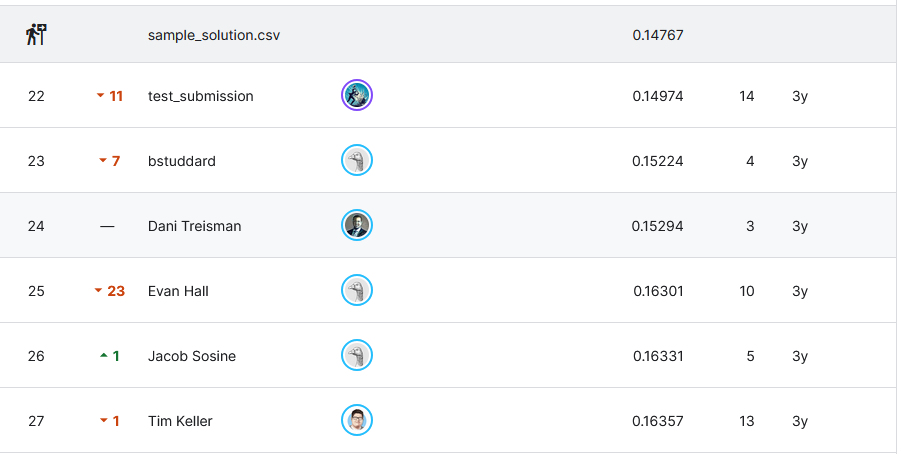



# Deeper Neural Network with more structured Lightning Code

We were doing a lot of tinkering before, but in this step we wanted to make the code more robust and add some more layers to our MLP. So we started by taking some inspiration from assignment 2.

In [69]:
from torch.utils.data import random_split

batch_size = 256
training_dataset, val_dataset = random_split(
    dataset,
    (0.7, 0.3) # 70% 30% training testing split
)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [70]:
def describe(model, **kwargs):
    return torchinfo.summary(model,
                             input_size=(batch_size, 11),
                             col_names=['input_size', 'output_size', 'num_params'],
                             row_settings=['ascii_only'])

We set the training function to be able to run with a GPU, but we ran out of free GPU time...oops! It's ok though, the models still run in a reasonable time with the CPU.

In [71]:
import shutil
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything

def train(model, max_epochs=3):
    name = model.__class__.__name__
    shutil.rmtree(f'./lightning_logs/{name}', ignore_errors=True)
    logger = CSVLogger('./lightning_logs', name=name)
    trainer = Trainer(max_epochs=max_epochs, logger=logger, deterministic=False) # remove deterministic = True because we want GPU acceleration
    trainer.fit(model,
                train_dataloaders=training_dataloader,
                val_dataloaders=val_dataloader)

In [72]:
def show_metrics(name):
    df = pd.read_csv(f'./lightning_logs/{name}/version_0/metrics.csv')
    df.set_index('step', inplace=True)
    ax = df[['train_step_acc']].dropna().plot()
    df[['val_step_acc']].dropna().plot(ax=ax);
    return df[['val_step_acc']].dropna().round(2)

In [73]:
from typing import Tuple
class BaseModel(L.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.accuracy = torchmetrics.classification.BinaryAccuracy()
        self.model = self.build_model()

    def build_model(self):
        raise Exception("Not yet implemented")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def forward(self, x):
        return self.model(x).squeeze(1)

    def loss(self, logits, target):
        return nn.functional.binary_cross_entropy_with_logits(logits, target)

    def shared_step(self, mode:str, batch:Tuple[torch.Tensor, torch.Tensor], batch_index:int):
        x, target = batch
        output = self.forward(x)
        loss = self.loss(output, target.float()) # Ensure target is float for BCEWithLogitsLoss
        self.accuracy(output, target) # target here needs to be int or bool for BinaryAccuracy
        self.log(f"{mode}_step_acc", self.accuracy, prog_bar=True)
        self.log(f"{mode}_step_loss", loss, prog_bar=False)
        return loss

    def training_step(self, batch, batch_index):
        return self.shared_step('train', batch, batch_index)

    def validation_step(self, batch, batch_index):
        return self.shared_step('val', batch, batch_index)

    def test_step(self, batch, batch_index):
        return self.shared_step('test', batch, batch_index)

In [74]:
class MLP(BaseModel):
    def __init__(self, num_classes, hidden):
        self.hidden = hidden
        super().__init__(num_classes)

    def build_model(self):
        return nn.Sequential(
            nn.Linear(11,self.hidden),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden, 1))


In [75]:
describe(MLP(1, 64))

Layer (type)                             Input Shape               Output Shape              Param #
MLP                                      [256, 11]                 [256]                     --
+ Sequential                             [256, 11]                 [256, 1]                  --
|    + Linear                            [256, 11]                 [256, 64]                 768
|    + ReLU                              [256, 64]                 [256, 64]                 --
|    + Linear                            [256, 64]                 [256, 1]                  65
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.21
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 0.00
Estimated Total Size (MB): 0.15

In [76]:
model = MLP(1, 64)
train(model)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │    833 │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 833                                                                                              
Non-trainable params: 0                                                                                            
Total params: 833                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


,val_step_acc
step,
796,0.71
1593,0.78
2390,0.81


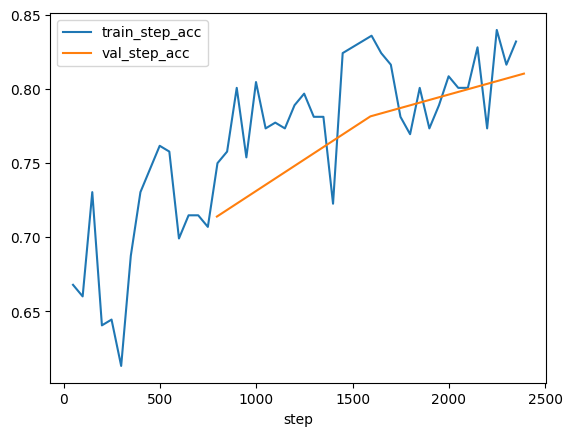

In [77]:
show_metrics('MLP')

Nice! Our updated code works. Let's try with more epochs.

In [78]:
model = MLP(1, 64)
train(model, max_epochs=10)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │    833 │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 833                                                                                              
Non-trainable params: 0                                                                                            
Total params: 833                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


,val_step_acc
step,
796,0.72
1593,0.82
2390,0.89
3187,0.91
3984,0.92
4781,0.92
5578,0.92
6375,0.92
7172,0.93


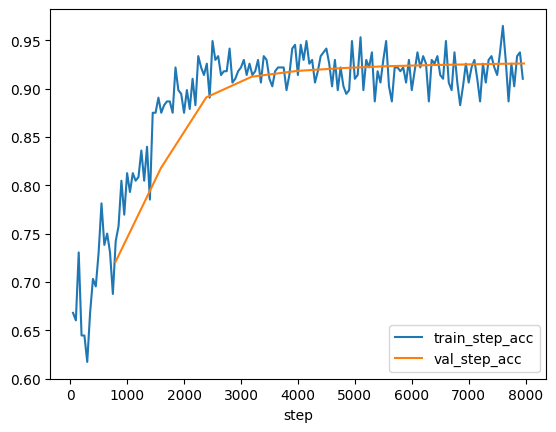

In [79]:
show_metrics('MLP')

In [80]:
to_kaggle_submission(model, filename='02_better_lightning_submission')

After trying this file, our log loss got marginally better, and the accuracy is still holding strong around 93%

**IMPORTANT NOTE**: An accuracy of about 92% is what we would expect. Umpires are unpredictable and can make mistakes. An [exploratory data analysis](https://colab.research.google.com/drive/1lEXBMvEbwlHdH-IaRvL_n4pRyy7yCxda?usp=sharing) by one of the group members several years ago found that the average accuracy for umpires in the 2022 season (the same year of this dataset) was about 93-94%. This means that our models are performing about as well as they should be. Any more than 96% and they would DEFINITELY be overfitting.

# Experimenting with different options to improve Log Loss

First we wanted to try making our neural net deeper just to see what effect that might have on our log loss

In [34]:
class DeeperMLP(BaseModel):
    def __init__(self, num_classes, hidden):
        self.hidden = hidden
        super().__init__(num_classes)

    def build_model(self):
        return nn.Sequential(
            nn.Linear(11,self.hidden),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden, self.num_classes))

In [35]:
describe(DeeperMLP(1, 64))

Layer (type)                             Input Shape               Output Shape              Param #
DeeperMLP                                [256, 11]                 [256]                     --
+ Sequential                             [256, 11]                 [256, 1]                  --
|    + Linear                            [256, 11]                 [256, 64]                 768
|    + ReLU                              [256, 64]                 [256, 64]                 --
|    + Linear                            [256, 64]                 [256, 64]                 4,160
|    + ReLU                              [256, 64]                 [256, 64]                 --
|    + Linear                            [256, 64]                 [256, 64]                 4,160
|    + ReLU                              [256, 64]                 [256, 64]                 --
|    + Linear                            [256, 64]                 [256, 1]                  65
Total params: 9,153
Trainabl

In [36]:
model = DeeperMLP(1, 64)
train(model, max_epochs=10)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │  9.2 K │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 9.2 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.2 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 9                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


,val_step_acc
step,
796,0.84
1593,0.91
2390,0.92
3187,0.92
3984,0.92
4781,0.92
5578,0.92
6375,0.92
7172,0.92


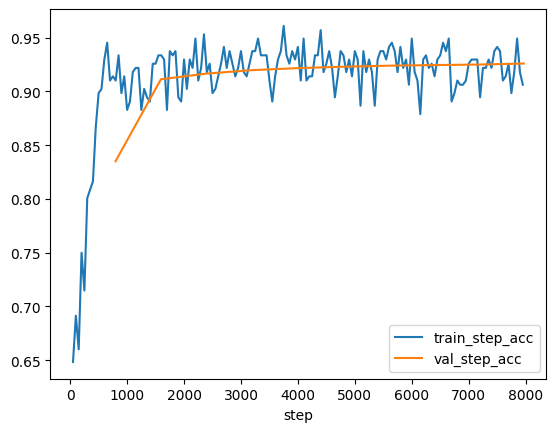

In [37]:
show_metrics('DeeperMLP')

In [38]:
to_kaggle_submission(model, filename='03_deeper_submission')

Although our accuracy remained hovering around our ideal 93%, our log loss only got marginally better.

# Lets try playing with the learning rate

We also tried playing with the learning rate to see if we could get it to train faster.

In [39]:
from typing import Tuple

class BaseModel(L.LightningModule):
    def __init__(self, num_classes, learning_rate=0.001): # Added learning_rate parameter
        super().__init__()
        self.num_classes = num_classes
        self.learning_rate = learning_rate # Store learning rate
        self.accuracy = torchmetrics.classification.BinaryAccuracy()
        self.model = self.build_model()

    def build_model(self):
        raise Exception("Not yet implemented")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate) # Use self.learning_rate

    def forward(self, x):
        return self.model(x).squeeze(1)

    def loss(self, logits, target):
        return nn.functional.binary_cross_entropy_with_logits(logits, target)

    def shared_step(self, mode:str, batch:Tuple[torch.Tensor, torch.Tensor], batch_index:int):
        x, target = batch
        output = self.forward(x)
        loss = self.loss(output, target.float()) # Ensure target is float for BCEWithLogitsLoss
        self.accuracy(output, target) # target here needs to be int or bool for BinaryAccuracy
        self.log(f"{mode}_step_acc", self.accuracy, prog_bar=True)
        self.log(f"{mode}_step_loss", loss, prog_bar=False)
        return loss

    def training_step(self, batch, batch_index):
        return self.shared_step('train', batch, batch_index)

    def validation_step(self, batch, batch_index):
        return self.shared_step('val', batch, batch_index)

    def test_step(self, batch, batch_index):
        return self.shared_step('test', batch, batch_index)


class MLP(BaseModel):
    def __init__(self, num_classes, hidden, learning_rate=0.001):
        self.hidden = hidden
        super().__init__(num_classes, learning_rate)

    def build_model(self):
        return nn.Sequential(
            nn.Linear(11,self.hidden),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden, self.num_classes))

print("BaseModel and MLP classes updated to support learning rate tuning.")

BaseModel and MLP classes updated to support learning rate tuning.


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


--- Training with Learning Rate: 0.01 and Hidden Size: 64 ---


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │    833 │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 833                                                                                              
Non-trainable params: 0                                                                                            
Total params: 833                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


,val_step_acc
step,
796,0.84
1593,0.92
2390,0.92
3187,0.92
3984,0.92
4781,0.93
5578,0.93
6375,0.93
7172,0.93


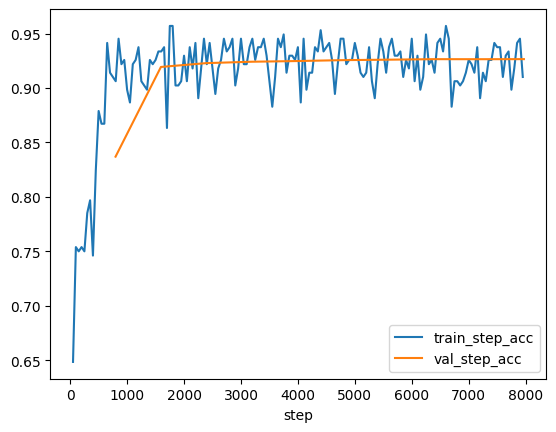

In [40]:
print('--- Training with Learning Rate: 0.01 and Hidden Size: 64 ---')
model_lr_01_h64 = MLP(1, 64, learning_rate=0.01)
train(model_lr_01_h64, max_epochs=10)
show_metrics('MLP')

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


--- Training with Learning Rate: 0.001 and Hidden Size: 64 ---


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │    833 │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 833                                                                                              
Non-trainable params: 0                                                                                            
Total params: 833                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


,val_step_acc
step,
796,0.72
1593,0.79
2390,0.82
3187,0.87
3984,0.90
4781,0.91
5578,0.92
6375,0.92
7172,0.92


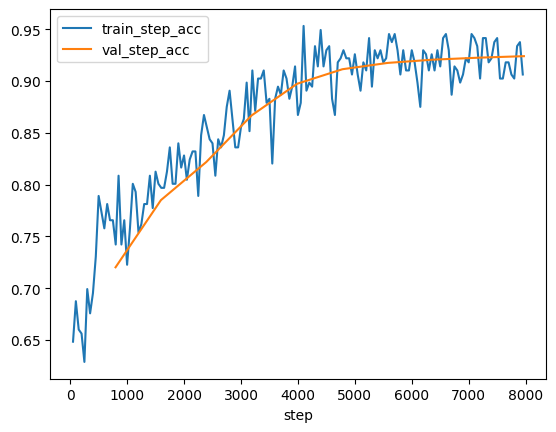

In [41]:
print('--- Training with Learning Rate: 0.001 and Hidden Size: 64 ---')
model_lr_001_h64 = MLP(1, 64, learning_rate=0.001)
train(model_lr_001_h64, max_epochs=10)
show_metrics('MLP')


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


--- Training with Learning Rate: 0.0001 and Hidden Size: 64 ---


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │    833 │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 833                                                                                              
Non-trainable params: 0                                                                                            
Total params: 833                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


,val_step_acc
step,
796,0.66
1593,0.67
2390,0.67
3187,0.67
3984,0.67
4781,0.68
5578,0.69
6375,0.71
7172,0.74


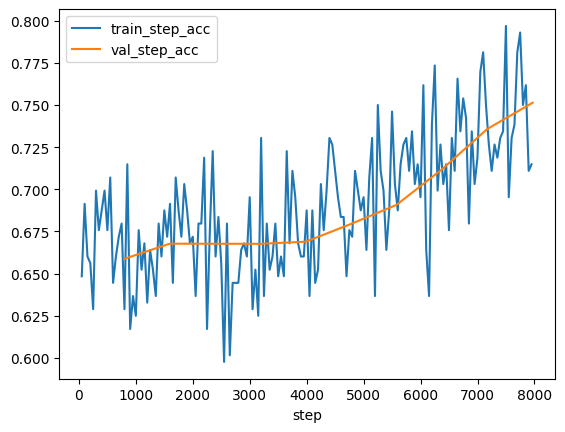

In [42]:
print('--- Training with Learning Rate: 0.0001 and Hidden Size: 64 ---')
model_lr_0001_h64 = MLP(1, 64, learning_rate=0.0001)
train(model_lr_0001_h64, max_epochs=10)
show_metrics('MLP')

Although the learning rate of 0.01 trains very quickly it may be overcorrecting.
The learning rate of 0.0001 only ends up hovering around less than 70% accuracy.
0.001 seems like a good sweetspot.

## Implement Data Scaling

Next we tried normalizing the input data to see if that affects our log loss. This way, larger inputs like `release_speed` do not overshadow other inputs like `pfx_x`. It also works better for gradient descent as we have a fixed learning rate.

To implement these changes we used `StandardScaler` from `scikit-learn`.

We had to modify our preprocessing pipeline and kaggle csv output functions to take these changes into consideration. This is because the scalar calculated from the input needs to be the same scalar that is applied to the unseen testing data.

In [43]:
from sklearn.preprocessing import StandardScaler

def preprocessing_pipeline(df, is_train=True, scaler=None):
    numeric_features = [
    "plate_x", # Horizontal position of the ball when it crosses home plate from the catcher's perspective.
    "plate_z", # Vertical position of the ball when it crosses home plate from the catcher's perspective.
    "sz_top", # Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
    "sz_bot", # Top of the batter's strike zone set by the operator when the ball is halfway to the plate.
    "balls", # Pre-pitch number of balls in count.
    "strikes", # Pre-pitch number of strikes in count.
    "release_speed", # Out of hand release speed.
    "pfx_x",
    "pfx_z",
    ]

    categorical_features = [
        "p_throws", # Handedness of the pitcher "L/R"
        "stand", # Handedness of the batter "L/R",
        # "pitch_type", # Pitch type
    ]

    if is_train:
        target = ["is_strike"]
        df_simplified = df[numeric_features + categorical_features + target].copy()
    else:
        df_simplified = df[numeric_features + categorical_features].copy()

    df_simplified["p_throws"] = df_simplified["p_throws"].map({"L": 0, "R": 1})
    df_simplified["stand"] = df_simplified["stand"].map({"L": 0, "R": 1})

    # Scaling numeric features
    if is_train:
        scaler = StandardScaler()
        df_simplified[numeric_features] = scaler.fit_transform(df_simplified[numeric_features])
    elif scaler is not None:
        df_simplified[numeric_features] = scaler.transform(df_simplified[numeric_features])
    else:
        raise ValueError("Scaler must be provided for testing data.")

    if is_train:
        return df_simplified, scaler
    else:
        return df_simplified



# Re-run preprocessing for training data to get the scaled dataframe and the scaler
train_df_simplified, scaler = preprocessing_pipeline(train_df, is_train=True)

# Update inputs and targets for the model with the scaled data
inputs = torch.tensor(
    train_df_simplified.drop(columns=["is_strike"]).values,
    dtype=torch.float32
)

targets = torch.tensor(
    train_df_simplified["is_strike"].values,
    dtype=torch.int64
)

# Re-create dataset and dataloaders with scaled data
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# Update the training and validation dataloaders used in the structured Lightning code
from torch.utils.data import random_split

batch_size = 256
training_dataset, val_dataset = random_split(
    dataset,
    (0.7, 0.3)
)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

def to_kaggle_submission(model, filename="submission", scaler=None):
  # 1. Get your raw model outputs (Logits)
  all_probs = []
  all_ids = []

  # Pass the scaler to preprocessing_pipeline for test data
  test_df_simplified = preprocessing_pipeline(test_df, is_train=False, scaler=scaler)

  inputs_test = torch.tensor(
      test_df_simplified.values,
      dtype=torch.float32
  )
  uids_test = torch.tensor(
      test_df['uid'].values,
      dtype=torch.int64
  )

  dataset_test = torch.utils.data.TensorDataset(inputs_test, uids_test)
  test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=256, shuffle=False) # Changed shuffle to False for consistent ID ordering

  model.eval() # Turn off training mode
  with torch.no_grad():
      for batch_x, batch_ids in test_loader:
          logits = model(batch_x)

          # 2. APPLY SOFTMAX to get probabilities (0.0 to 1.0)
          probs = F.sigmoid(logits)

          all_probs.extend(probs.squeeze().tolist())
          all_ids.extend(batch_ids.tolist())

  # 3. Create the submission dataframe
  submission = pd.DataFrame({
      'uid': all_ids,
      'is_strike': all_probs # This is now a float, e.g., 0.874, not just 0 or 1
  })

  # Clip it between 0.01 and 0.99 for better log loss in submission
  submission['is_strike'] = submission['is_strike'].clip(lower=0.01, upper=0.99)

  submission.to_csv(f'{filename}.csv', index=False)

print("Data scaling and pipeline updated successfully.")


Data scaling and pipeline updated successfully.


Now we will train it with the scaled data

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


--- Training with Learning Rate: 0.01 ---


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │    833 │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 833                                                                                              
Non-trainable params: 0                                                                                            
Total params: 833                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


,val_step_acc
step,
796,0.86
1593,0.93
2390,0.93
3187,0.93
3984,0.93
4781,0.93


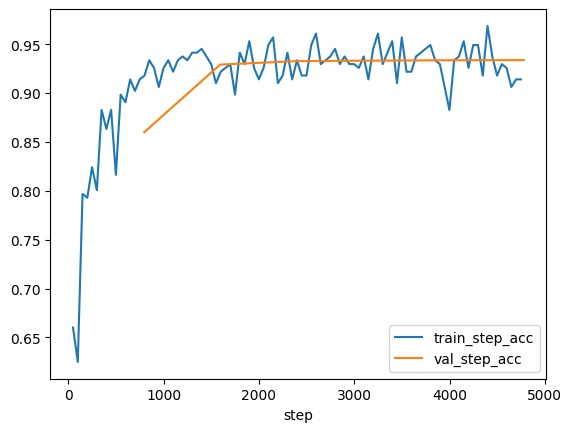

In [44]:

print('--- Training with Learning Rate: 0.01 ---')
model_lr_001_h64_scaled = MLP(1, 64, learning_rate=0.001)
train(model_lr_001_h64_scaled, max_epochs=6)
show_metrics('MLP')

In [45]:
to_kaggle_submission(model_lr_001_h64_scaled, filename='04_scaled_submission', scaler=scaler)

Wow, this seems to be training much quicker and it improved our log loss! Finally, we tried to make one more small change to see if we could improve it a little more.

## Add Dropout Regularization

For our final improvement, we tried adding dropout regularization on top of the scaling. Since we did this, we also increased the hidden layer size from 64 to 256 as the dropout should help offset any overfitting.

In [46]:
from typing import Tuple

class BaseModel(L.LightningModule):
    def __init__(self, num_classes, learning_rate=0.001):
        super().__init__()
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.accuracy = torchmetrics.classification.BinaryAccuracy()
        self.model = self.build_model()

    def build_model(self):
        raise Exception("Not yet implemented")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        return self.model(x).squeeze(1)

    def loss(self, logits, target):
        return nn.functional.binary_cross_entropy_with_logits(logits, target)

    def shared_step(self, mode:str, batch:Tuple[torch.Tensor, torch.Tensor], batch_index:int):
        x, target = batch
        output = self.forward(x)
        loss = self.loss(output, target.float())
        self.accuracy(output, target)
        self.log(f"{mode}_step_acc", self.accuracy, prog_bar=True)
        self.log(f"{mode}_step_loss", loss, prog_bar=False)
        return loss

    def training_step(self, batch, batch_index):
        return self.shared_step('train', batch, batch_index)

    def validation_step(self, batch, batch_index):
        return self.shared_step('val', batch, batch_index)

    def test_step(self, batch, batch_index):
        return self.shared_step('test', batch, batch_index)


class MLP(BaseModel):
    def __init__(self, num_classes, hidden, learning_rate=0.001, dropout_rate=0.2):
        self.hidden = hidden
        self.dropout_rate = dropout_rate
        super().__init__(num_classes, learning_rate)

    def build_model(self):
        return nn.Sequential(
            nn.Linear(11, self.hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.hidden, 1)
        )

class DeeperMLP(BaseModel):
    def __init__(self, num_classes, hidden, learning_rate=0.001, dropout_rate=0.2):
        self.hidden = hidden
        self.dropout_rate = dropout_rate
        super().__init__(num_classes, learning_rate)

    def build_model(self):
        return nn.Sequential(
            nn.Linear(11, self.hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.hidden, self.num_classes)
        )

print("MLP and DeeperMLP classes updated to include dropout regularization.")


MLP and DeeperMLP classes updated to include dropout regularization.


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


--- Training MLP with Dropout (rate=0.2) ---


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │  3.3 K │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 6                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


,val_step_acc
step,
796,0.89
1593,0.93
2390,0.93
3187,0.93
3984,0.93
4781,0.93
5578,0.93
6375,0.93
7172,0.93


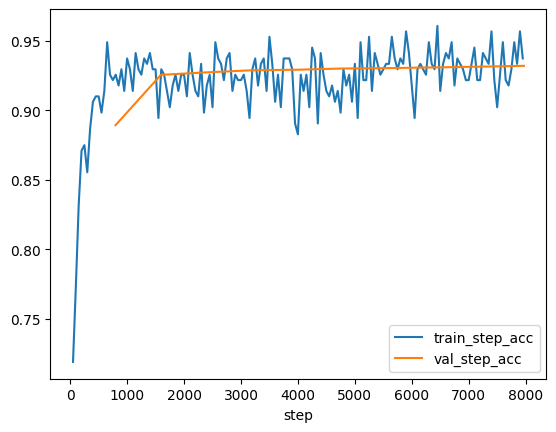

In [47]:
print('--- Training MLP with Dropout (rate=0.2) ---')
model_dropout = MLP(1, 256, learning_rate=0.001, dropout_rate=0.2)
train(model_dropout, max_epochs=10)
show_metrics('MLP')


In [48]:
to_kaggle_submission(model_dropout, filename='05_mlp_dropout_submission', scaler=scaler)

We also tried `DeeperMLP` with dropout.

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


--- Training DeeperMLP with Dropout (rate=0.2) ---


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name     ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ accuracy │ BinaryAccuracy │      0 │ train │     0 │
│ 1 │ model    │ Sequential     │  134 K │ train │     0 │
└───┴──────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 134 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 134 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 12                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


,val_step_acc
step,
796,0.91
1593,0.92
2390,0.93
3187,0.93
3984,0.93
4781,0.93
5578,0.93
6375,0.93
7172,0.93


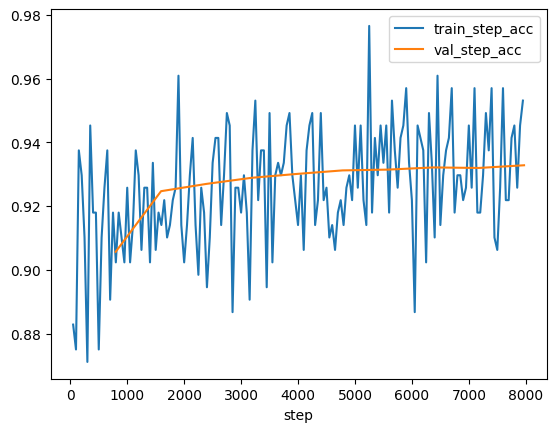

In [49]:
print('--- Training DeeperMLP with Dropout (rate=0.2) ---')
model_deeper_dropout = DeeperMLP(1, 256, learning_rate=0.001, dropout_rate=0.2)
train(model_deeper_dropout, max_epochs=10)
show_metrics('DeeperMLP')


In [50]:
to_kaggle_submission(model_deeper_dropout, filename='06_deeper_mlp_dropout_submission', scaler=scaler)

# Conclusions

It seems like the best model we were able to get had the following characteristics.

- MLP with single hidden layer
- Eleven carefully selected inputs and one raw logit output
- Train with 0.7-0.3 train-test split and batch size of 256
- Learning rate of 0.001
- Hidden layer with? 256 dimensions
- Dropout of 0.2
- Scaled inputs with standard scalar
- ~92-93% Accuracy

Pretty good!

# Deployment

In order to deploy we needed two main things from this notebook. The first is our checkpoint file from our latest MLP model in the generated `lightning_logs` folder. Then we need to grab the scalar variable, which you can see in the next cel using `joblib`.

We can use these two files to reconstruct our model in a simple [gradio](https://www.gradio.app/) project. Here, you can play around with different inputs and try to see how confident our model is that an umpire calls a pitch either a strike or a ball. This was deployed on [Hugging Face](https://huggingface.io) and can be accessed [here](https://huggingface.co/spaces/ryan-don31/ML-Final-Project-DavidRyan).

# Usage example

Here is an example where our model could be very useful:

As discussed at the beginning of the project, the strike zone depends on the build of the batter. Taller players therefore have a larger strike zone that is further off the ground. Umpires sometimes struggle to adjust to this for players like Aaron Judge (6' 7").

The following is an example pitch we input into our system: [link here](https://ryan-don31-ml-final-project-davidryan.hf.space/?__theme=system&deep_link=nw40HBVSJXI)

As you may see, our system is predicting that the pitch has a high probability of being called a strike given the current conditions.

After some detective work, we were able to find the same pitch on the MLB statcast website that keeps track of every pitch [here](https://baseballsavant.mlb.com/sporty-videos?playId=2d5f1447-66e2-4c57-ade6-3f0247aac218).

If you pay close attention you will see that according to the computer on the broadcast the pitch was objectively outside the strike zone and should have been called a ball (if it was a strike the circle would be white and filled in).

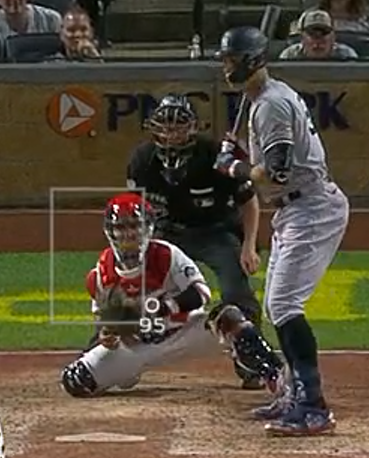

If you keep watching though, youll see that the umpire actually called it a strike (they typically point to the right and yell "STRIKE!"). This means our model worked! Obviously this was a close pitch and it will not work 100% of the time, but you've got to admit thats pretty cool!

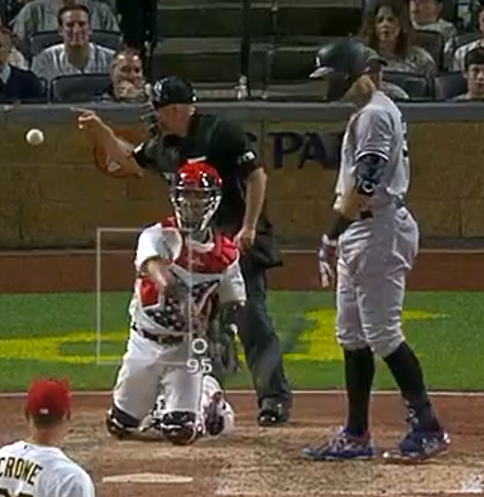



In [51]:
# This is a quick way to export the scaler variable
!pip install joblib
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Log Loss
Here are our final log loss scores for each step in the process:

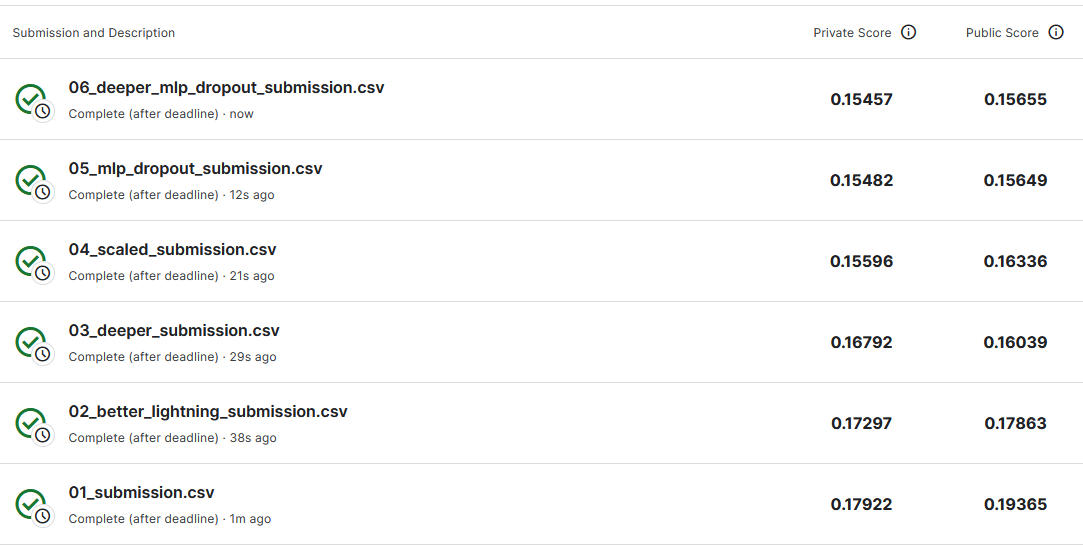